In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
from model_builder import create_dnn_model, create_cnn_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from model_builder import SimpleDNN, SimpleCNN

input_csv = "patches_with_majority_pathology.csv"
df = pd.read_csv(input_csv)
#print(df.head())

feature_cols = [str(i) for i in range(1536)]
X = df[feature_cols].values.astype(np.float32)
y = LabelEncoder().fit_transform(df['label'].values).astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Get pathology training data

In [2]:
input_csv = "patches_with_majority_pathology.csv"
df = pd.read_csv(input_csv)
#print(df.head())
feature_cols = [str(i) for i in range(1536)]
X = df[feature_cols].values.astype(np.float32)
y = LabelEncoder().fit_transform(df['label'].values).astype(np.int64)
dnn_output_path = "models/dnn_pathology_model.pth"
df = pd.read_csv(input_csv)
labelEncoder = LabelEncoder().fit(df['label'].values)

Split data into training and testing sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 4414
Testing set size: 1104


Train DNN model

In [4]:
create_dnn_model(X_train, X_test, y_train, y_test , dnn_output_path, labelEncoder, epochs=1)

DNN: Epoch 1 completed. Average Loss: 0.4032
DNN Accuracy: 0.920
DNN model + labels saved to models/dnn_pathology_model.pth


Train CNN model

In [5]:
cnn_output_path = "models/cnn_pathology_model.pth"
create_cnn_model(X_train, X_test, y_train, y_test, cnn_output_path, labelEncoder,epochs=1)

CNN: Epoch 1 completed. Average Loss: 0.4679
CNN Accuracy: 0.899
CNN model + labels saved to models/cnn_pathology_model.pth


Load trained models and perform dummy predictions

In [6]:
from model_builder import SimpleDNN, SimpleCNN
import torch
import torch.nn.functional as F

# Load DNN model
dnn_model = SimpleDNN(1536, len(np.unique(y_train)))
checkpoint_dnn = torch.load(dnn_output_path)
dnn_model.load_state_dict(checkpoint_dnn.get("state_dict", checkpoint_dnn))
dnn_model.eval()

# Load CNN model
cnn_model = SimpleCNN(len(np.unique(y_train)))
checkpoint_cnn = torch.load(cnn_output_path)
cnn_model.load_state_dict(checkpoint_cnn.get("state_dict", checkpoint_cnn))
cnn_model.eval()

/tmp/ipykernel_28524/1246320192.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dnn = torch.load(dnn_output_path)
/tmp/ipykernel_28524/1246320192.py:13: Futur

SimpleCNN(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=12288, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=7, bias=True)
  )
)

In [7]:
# Load saved label classes from the DNN model checkpoint
checkpoint = torch.load(dnn_output_path)
if "label_classes" in checkpoint:
    original_labels = np.array(checkpoint["label_classes"])

# One sample demo predictions of DNN model
sample_input = torch.tensor(X_test[0]).unsqueeze(0)  # Add batch dimension
dnn_output = dnn_model(sample_input)
dnn_pred_enc = F.softmax(dnn_output, dim=1).argmax(dim=1).item()
dnn_pred_label = original_labels[dnn_pred_enc]
true_label = original_labels[y_test[0]]
print(f"DNN model prediction: {dnn_pred_label} (encoded: {dnn_pred_enc}), True: {true_label} (encoded: {y_test[0]})")

# One sample demo predictions of CNN model
sample_input = torch.tensor(X_test[0]).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
cnn_output = cnn_model(sample_input)
cnn_pred_enc = F.softmax(cnn_output, dim=1).argmax(dim=1).item()
cnn_pred_label = original_labels[cnn_pred_enc]
print(f"CNN model prediction: {cnn_pred_label} (encoded: {cnn_pred_enc}), True: {true_label} (encoded: {y_test[0]})")


DNN model prediction: Fibro-muscular tissue (encoded: 1), True: Fibro-muscular tissue (encoded: 1)
CNN model prediction: Fibro-muscular tissue (encoded: 1), True: Fibro-muscular tissue (encoded: 1)


/tmp/ipykernel_28524/1659000359.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(dnn_output_path)


In [8]:
print(df.columns)

Index(['Patch_X', 'Patch_Y', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '1527', '1528', '1529', '1530', '1531', '1532', '1533', '1534', '1535',
       'label'],
      dtype='object', length=1539)


## Visualize Sample points

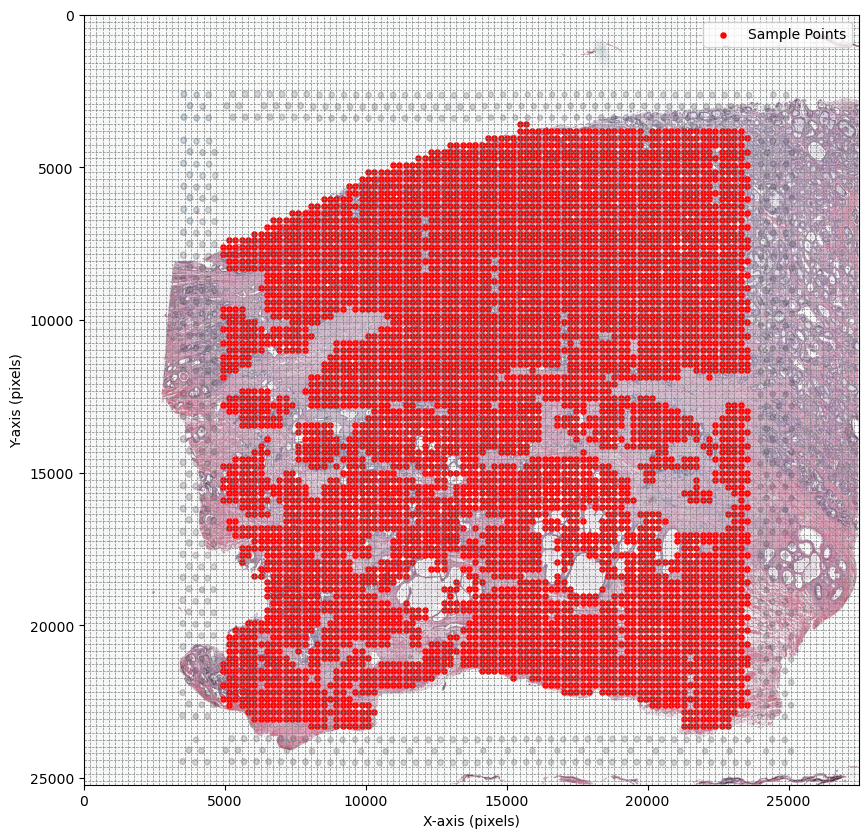

In [9]:
from plotter import visualize_tissue_image_with_samples

image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples(image_path, df, 27482, 25219)



## Visualize Ground Truth Labels on Tissue Image

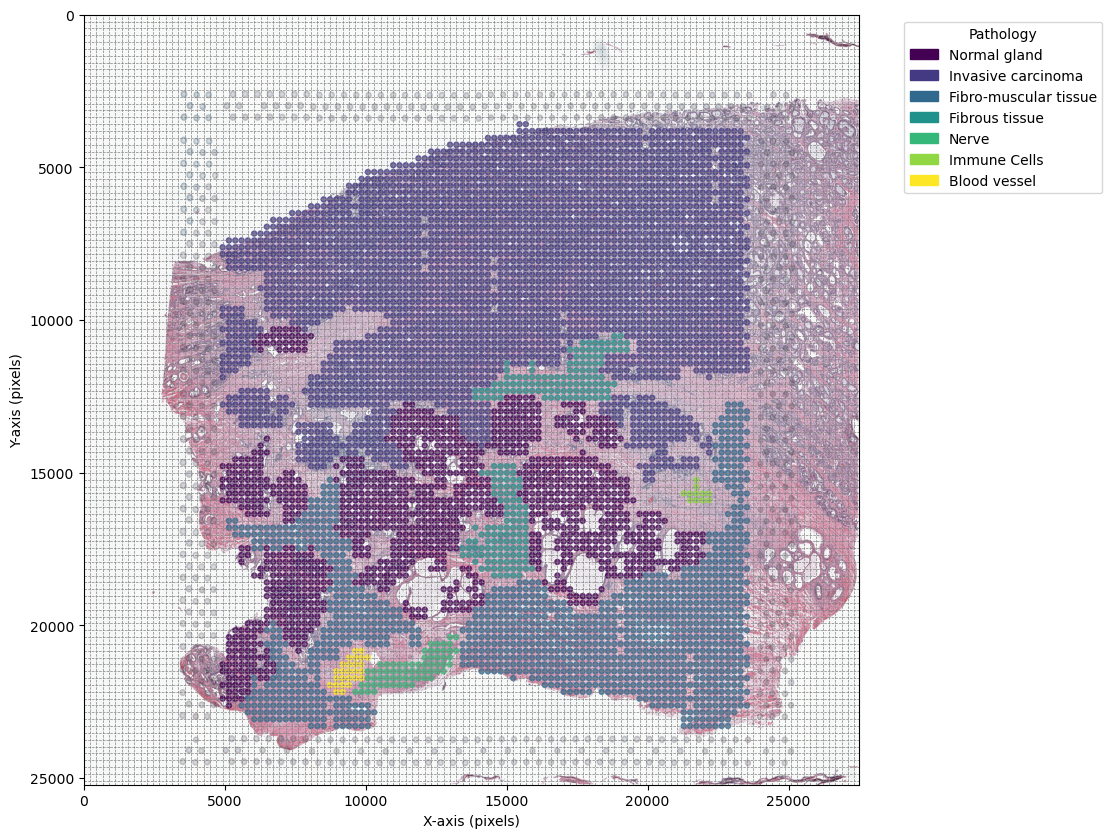

In [10]:
from plotter import visualize_tissue_image_with_samples_color_labels

image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples_color_labels(image_path, df, 27482, 25219)
